In [1]:
# Задача исследовать данные stepik об оттоке пользователей курса 

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

In [3]:
df = pd.read_csv('https://stepik.org/media/attachments/course/4852/event_data_train.zip')

In [4]:
df.head()

,step_id,timestamp,action,user_id
0,32815,1434340848,viewed,17632
1,32815,1434340848,passed,17632
2,32815,1434340848,discovered,17632
3,32811,1434340895,discovered,17632
4,32811,1434340895,viewed,17632


In [5]:
df.dtypes

step_id       int64
timestamp     int64
action       object
user_id       int64
dtype: object

In [6]:
df.isna().sum()

step_id      0
timestamp    0
action       0
user_id      0
dtype: int64

In [7]:
df.describe()

,step_id,timestamp,user_id
count,3.480703e+06,3.480703e+06,3.480703e+06
mean,3.487358e+04,1.480288e+09,1.331468e+04
std,1.422243e+04,3.068906e+07,7.779099e+03
min,3.045600e+04,1.434341e+09,1.000000e+00
25%,3.217900e+04,1.450271e+09,6.642000e+03
50%,3.292900e+04,1.483904e+09,1.320800e+04
75%,3.348100e+04,1.507889e+09,2.014400e+04
max,1.584330e+05,1.526773e+09,2.679800e+04


In [8]:
df.action.unique()

array(['viewed', 'passed', 'discovered', 'started_attempt'], dtype=object)

In [9]:
df['Datetime'] = pd.to_datetime(df.timestamp, unit='s')

In [10]:
print(df.Datetime.min(), df.Datetime.max())

2015-06-15 04:00:48 2018-05-19 23:33:31


In [11]:
df['Day'] = df.Datetime.dt.date

In [12]:
uniq_by_date = df.groupby('Day').user_id.nunique().reset_index()

<Axes: xlabel='Day', ylabel='user_id'>

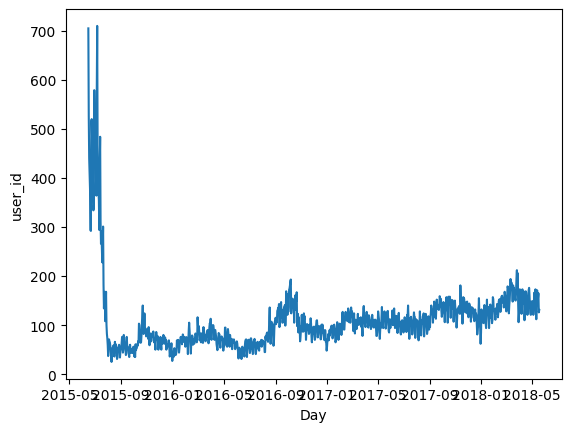

In [13]:
sns.lineplot(uniq_by_date, x='Day', y='user_id')

<Axes: >

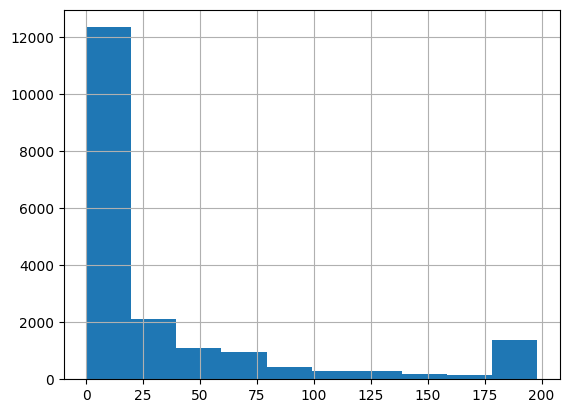

In [14]:
df.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index().passed.hist()

In [15]:
user_events = df.pivot_table(index='user_id', columns='action', values='step_id', aggfunc='count', fill_value=0).reset_index()

In [16]:
sub_df = pd.read_csv('https://stepik.org/media/attachments/course/4852/submissions_data_train.zip')

In [17]:
sub_df.isna().sum()

step_id              0
timestamp            0
submission_status    0
user_id              0
dtype: int64

In [18]:
sub_df['Datetime'] = pd.to_datetime(sub_df.timestamp, unit='s')

In [19]:
sub_df['Date'] = sub_df.Datetime.dt.date

In [20]:
users_subs = sub_df.pivot_table(index='user_id', columns='submission_status', values='step_id', aggfunc='count', fill_value=0).reset_index().sort_values('correct', ascending=False)

In [21]:
gaps_data = df[['user_id', 'timestamp', 'Day']].drop_duplicates(subset=['Day']).groupby('user_id')['timestamp'].apply(list) \
    .apply(np.diff).values

In [22]:
gaps_data = pd.Series(np.concatenate(gaps_data, axis=0))

In [23]:
gaps_data.quantile(0.90) / (24*60*60)

np.float64(15.203456018518562)

In [24]:
users = df.groupby('user_id').agg({'timestamp':'max'}).reset_index()

In [25]:
users = users.merge(users_subs, on=['user_id'], how='left')
users.fillna(0, inplace=True)

In [26]:
users = users.merge(user_events, on='user_id', how='left')
users.fillna(0, inplace=True)

In [27]:
uniq_days = df.groupby('user_id').agg({'Day':'nunique'}).reset_index().rename(columns={'Day':'days_unique'})

In [28]:
users = users.merge(uniq_days, on='user_id', how='left')
users.fillna(0, inplace=True)

In [29]:
users['churned'] = np.where(((1526772811 - users.timestamp) > 24*60*60*30), 1, 0)

In [30]:
users['finished_course'] = np.where(users.passed > 40, 1,0)

In [31]:
#сколько в среднем дней потребовалось пользователям, которые прошли курс

users[users.finished_course == 1].days_unique.median()

np.float64(13.0)

<Axes: >

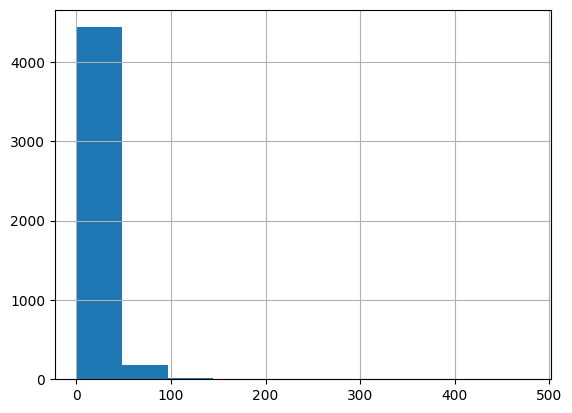

In [32]:
users[users.finished_course == 1].days_unique.hist()

In [33]:
#отбираем события, которые произошли от времени регистрации пользователя + 3 дня

In [34]:
df_min = df.merge(df.groupby('user_id').agg({'timestamp':'min'}).rename(columns={'timestamp':'min_timestamp'}).reset_index(), on='user_id', how='left')

In [35]:
threshold = 2*24*60*60

In [36]:
events_train = df_min[df_min.timestamp < df_min.min_timestamp + threshold]

In [37]:
#найдем степы, на которых пользователи отваливались
df_max = sub_df.merge(sub_df.groupby('user_id').agg({'timestamp':'max'}).rename(columns={'timestamp':'max_timestamp'}).reset_index(), on='user_id', how='left')

In [38]:
df_max[(df_max.timestamp == df_max.max_timestamp) & (df_max.submission_status == 'wrong')].groupby('step_id') \
    .agg({'user_id':'count'}).reset_index().sort_values('user_id', ascending=False)

,step_id,user_id
4,31978,154
28,32812,133
11,32031,97
19,32202,92
42,33481,78
...,...,...
43,33482,1
59,33686,1
57,33684,1
55,33676,1


In [39]:
# проверяем корректность. 4 дня ок – так как пользователь первое событие мог начать в середине дня
events_train.groupby('user_id').Day.nunique().max()

np.int64(3)

In [40]:
sub_train =  sub_df.merge(sub_df.groupby('user_id').agg({'timestamp':'min'}).rename(columns={'timestamp':'min_timestamp'}).reset_index(), on='user_id', how='left')

In [41]:
sub_train = sub_train[sub_train.timestamp < sub_train.min_timestamp + threshold]

In [42]:
#аналогично проверяем
sub_train.groupby('user_id').Date.nunique().max()

np.int64(3)

In [43]:
# Подготовим датафрейм для обучения
X = sub_train.groupby('user_id').Date.nunique().to_frame().reset_index()

In [44]:
steps_tried = sub_train.groupby('user_id').step_id.nunique().to_frame().reset_index().rename(columns={'step_id':'steps_tried'})

In [45]:
X = X.merge(steps_tried, on = 'user_id', how='left')

In [46]:
users_subs = sub_train.pivot_table(index='user_id', 
                                    columns='submission_status', 
                                    values='step_id', aggfunc='count', 
                                    fill_value=0) \
    .reset_index()

In [47]:
X = X.merge(users_subs, on = 'user_id', how='left')

In [48]:
X['correct_ratio'] = X.correct / (X.correct+ X.wrong)

In [49]:
X = X.merge(events_train.pivot_table(index='user_id', 
                           columns='action', 
                           values='step_id', 
                           aggfunc='count', fill_value=0) \
                            .reset_index()[['user_id','viewed']], 
            on='user_id', how='outer')

In [50]:
X.fillna(0, inplace=True)

In [51]:
X = X.merge(users[['user_id','finished_course','churned']], on='user_id', how='outer', )

In [52]:
X = X[~((X.churned == 0) & (X.finished_course == 0))]

In [53]:
y = X.finished_course

In [54]:
X = X.drop(columns=['finished_course','churned'])

In [55]:
X = X.set_index(X.user_id)
X = X.drop('user_id', axis=1)

In [56]:
y

0        0
1        0
2        1
3        0
4        0
        ..
19229    0
19230    0
19231    1
19232    0
19233    0
Name: finished_course, Length: 18439, dtype: int64

In [57]:
#пробуем строить модельки

In [128]:
from sklearn.model_selection import GridSearchCV, train_test_split, RandomizedSearchCV,cross_val_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import precision_score, recall_score, roc_auc_score, accuracy_score, confusion_matrix

In [59]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.2, random_state = 228) 

In [60]:
clf = RandomForestClassifier()

In [61]:
params = {'n_estimators':range(1,51,10), 'max_depth':range(1,25,5),'min_samples_split':range(1,10,2),'min_samples_leaf':range(1,10,2)}

In [62]:
search = RandomizedSearchCV(clf, params, cv=3, n_jobs=-1)

In [63]:
search.fit(X_train, y_train)

/Users/sergejknol/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py:540: FitFailedWarning: 
9 fits failed out of a total of 30.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
9 fits failed with the following error:
Traceback (most recent call last):
  File "/Users/sergejknol/miniconda3/lib/python3.12/site-packages/sklearn/model_selection/_validation.py", line 888, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/sergejknol/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 1466, in wrapper
    estimator._validate_params()
  File "/Users/sergejknol/miniconda3/lib/python3.12/site-packages/sklearn/base.py", line 666, in _validate_params
    validate_parameter_constr

RandomizedSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
                   param_distributions={'max_depth': range(1, 25, 5),
                                        'min_samples_leaf': range(1, 10, 2),
                                        'min_samples_split': range(1, 10, 2),
                                        'n_estimators': range(1, 51, 10)})

In [64]:
params2 = {'n_estimators':range(10,30,5), 'max_depth':range(1,10,2),'min_samples_split':range(5,10,2),'min_samples_leaf':range(5,10,2)}

In [65]:
search2 = GridSearchCV(clf, params2, cv=3, n_jobs=-1)

In [66]:
search2.fit(X_train, y_train)

/Users/sergejknol/miniconda3/lib/python3.12/site-packages/numpy/ma/core.py:2881: RuntimeWarning: invalid value encountered in cast
  _data = np.array(data, dtype=dtype, copy=copy,


GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(1, 10, 2),
                         'min_samples_leaf': range(5, 10, 2),
                         'min_samples_split': range(5, 10, 2),
                         'n_estimators': range(10, 30, 5)})

In [67]:
params3 = {'n_estimators':range(8,14), 'max_depth':range(5,10),'min_samples_split':range(5,10),'min_samples_leaf':range(6,8)}

In [68]:
search3 = GridSearchCV(clf, params3, cv=3, n_jobs=-1)

In [69]:
search3.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'max_depth': range(5, 10),
                         'min_samples_leaf': range(6, 8),
                         'min_samples_split': range(5, 10),
                         'n_estimators': range(8, 14)})

In [70]:
clf = search3.best_estimator_

In [71]:
predictions = clf.predict(X_test)
precision = precision_score(y_test, predictions)
roc_auc = roc_auc_score(y_test, predictions)
recal = recall_score(y_test, predictions)

In [72]:
print(precision, roc_auc, recal)

0.7730307076101469 0.7882570595505973 0.6376651982378855


In [73]:
# неплохо, попробуем кратно больше

In [74]:
rf = RandomForestClassifier(n_estimators=100, n_jobs=2, 
                            min_samples_leaf=10, min_samples_split=10, 
                            class_weight='balanced')

In [75]:
rf.fit(X_train, y_train)
pred_proba = rf.predict_proba(X_test)
roc_score = roc_auc_score(y_test, pred_proba[:, 1])
print('roc на test', roc_score)

roc на test 0.9179737267454758


In [76]:
pred = rf.predict(X_test)
roc_score = roc_auc_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

In [77]:
print(precision, roc_score, recall)

0.535690897184021 0.8229225430228504 0.9008810572687225


In [88]:
rfcv = RandomForestClassifier(**rf.get_params())

cv_scores = cross_val_score(rfcv, X_train, y_train, scoring='roc_auc', cv=10, n_jobs=-1)
mean_cv_scores = np.mean(cv_scores)
print ('mean score', mean_cv_scores)

mean score 0.9251328414430251


In [111]:
params = {'n_estimators':range(50,101,10), 'min_samples_leaf':[10], 'min_samples_split':[10], 
                            'class_weight':['balanced']}

In [112]:
rfbig = RandomForestClassifier()

In [113]:
search_big = GridSearchCV(rfbig, params, cv=3, n_jobs=-1)

In [114]:
search_big.fit(X_train, y_train)

GridSearchCV(cv=3, estimator=RandomForestClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'min_samples_leaf': [10],
                         'min_samples_split': [10],
                         'n_estimators': range(50, 101, 10)})

In [116]:
testrf = search_big.best_estimator_

In [147]:
y_prob = testrf.predict_proba(X_test)[:, 1]
threshold = 0.9
y_pred = (y_prob >= threshold).astype(int)
roc_auc = roc_auc_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
confm = pd.DataFrame(confusion_matrix(y_test, y_pred))

In [148]:
print(precision, roc_score, recall)

0.9056122448979592 0.8236419674832821 0.3909691629955947


In [150]:
confm

,0,1
0,2743,37
1,553,355


In [133]:
pred = testrf.predict(X_test)
confm = pd.DataFrame(confusion_matrix(y_test, pred))
roc_score = roc_auc_score(y_test, pred)
precision = precision_score(y_test, pred)
recall = recall_score(y_test, pred)

In [132]:
print(precision, roc_score, recall)

0.5370978332239001 0.8236419674832821 0.9008810572687225


In [134]:
confm

,0,1
0,2075,705
1,90,818


In [135]:
y_test.value_counts()

finished_course
0    2780
1     908
Name: count, dtype: int64